## HMM EXAMPLES 

In [1]:
# do all the imports
%matplotlib inline
import sys, os,time
import numpy as np
import pandas as pd
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

#homedir = os.path.expanduser('~')
#sys.path.append(os.path.join(homedir,'Nextcloud','github','scikit-speech'))
from pyspch import libhmm 
from pyspch import libhmm_plot as hmmplot
from pyspch import utils as spchu
import  pyspch
print(pyspch.__version__)

# print all variable statements
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# graphical and print preferences
ldesign = 50
cmap_caramel = sns.light_palette("caramel",ldesign,input="xkcd")[0:20]
#cmap = cmap[0:20] 
#pd.reset_option('display.float_format')
#pd.set_option('precision',2)
pd.options.display.float_format = '{:,.3f}'.format
# option for no colormapping
#cmap = []

0.1.dev1


In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 2px  black solid !important;
    column-width: 60px;
    color: black !important;
}

# Example (1) - Course Notes

In [3]:
# basic initialization creates a model without state transitions
hmm1 = libhmm.DHMM(n_states=3,n_symbols=2,labels=['A','B'],prob_style="lin")
# initialize as a simple left-to-right model
hmm1.init_topology(type="lr",selfprob=0.5)
# or you can with the initialization give transition and emission prob matrices
hmm1 = libhmm.DHMM(n_states=3,n_symbols=2,labels=['A','B'],prob_style="lin")
imat = np.array([1.0, 0.0, 0.])
emat = np.array([[.7,.3],[.1, .9],[.6,.4]])
tmat = np.array([[.6,.4,0.],[0.,.5,.5],[0.,0.,1.]]) 
hmm1 = libhmm.DHMM(n_states=3,labels=['A','B'],prob_style="lin",
                  transmat=tmat,initmat=imat,emissionmat=emat)
hmm1.print_model()
#

STATE MODEL



,S0,S1,S2
Pinit(S.),1.000,0.000,0.000
,,,
P(S0|S.),0.600,0.000,0.000
P(S1|S.),0.400,0.500,0.000
P(S2|S.),0.000,0.500,1.000


OBSERVATION MODEL



,S0,S1,S2
P(A|S.),0.700,0.100,0.600
P(B|S.),0.300,0.900,0.400


In [5]:
# set an observation sequence
Xl=['A','B','B','A','B']
X = [hmm1.labels.index(x) for x in Xl]
print("OBSERVATIONS\n")
pd.DataFrame([Xl,X],index=['LABEL','LBL_INDEX'])

OBSERVATIONS



,0,1,2,3,4
LABEL,A,B,B,A,B
LBL_INDEX,0,1,1,0,1


## Trellis Computations:
### 1. Forward Path Probabilities  (Viterbi, Forward Pass)

The **TRELLIS** is a matrix structure of shape (n_states,n_samples) containing in *cell (i,t)* the probability of being in *state S_i*

With *forward path*-probabilities we indicate that the Trellis is used to store the probabilities after having observerd *all observations up to X_t*.  (Note: the backward path probabilities measure the probabilities of generating the remainder of the observations when starting in 
the current cell) 

For the forward path probabilities, the Trellis is computed in a left-to-right *time synchronous* way, i.e. all cells (\*,t) are computed as soon as observation X(t) becomes available and for first order Markov models only knowledge of the current observation and the previous column of the trellis is required.

Hence the trellis computations are simple recursions (coming in 2 flavors):
- Viterbi Probability (computes the probability of the most likely path, is typically used for decoding/recognition and alignment)
$ P(i,t) = \max_j P(j,t-1) * P(j,i) * P(X(t)|i) $
- Forward Pass Probability (computes the "true" probability, is mainly used in training HMMs with the Forward-Backward algorithm)  
$ P(i,t) = \sum_j P(j,t-1) * P(j,i) * P(X(t)|i) $

Note:
- In both cases the sum- or max-operators need to be applied over all possible states that have a transition leading into *State S_i*
- The *state likelihoods* P(X(t)|i) are the likelihood of observing X(t) in State i (also called emmission likelihood)
- We further need some initialization probabilities, that tell us the probability of starting in a State with the first observation, so that we can start the recursion

The left-to-right recursive implementation is illustrated below for the basic example using **Viterbi**:
- the trellis is the main matrix structure
- the annotations above the matrix contain both the label of the observation and the state likelihoods

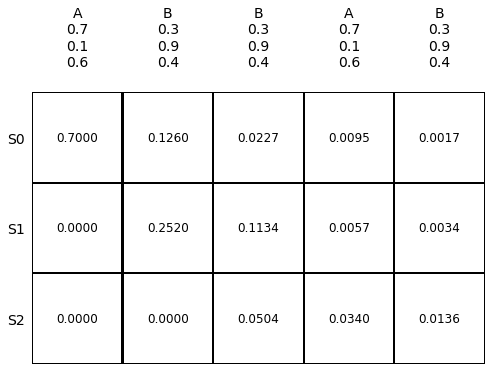

In [5]:
for i in range(len(X)):
    clear_output(wait=True);
    hmmplot.plot_trellis(hmm1,X[0:i+1],plot_frameprobs=True,fmt=".4f") 
    plt.close()
    time.sleep(1)

### All the computation in details
Set Debug True or False for greater levels of detaul

In [6]:
Debug= True
# initialization routine
def init_trellis(hmm,X):
    buf = np.zeros(len(hmm.states))
    state_likelihoods = hmm.compute_frameprobs(X)
    buf = hmm.initmat * state_likelihoods
    return(buf)
# single recursion step
def viterbi_step(hmm,X,buffer):
    newbuf = np.zeros(buffer.shape)
    state_likelihoods = hmm.compute_frameprobs(X)
    print('\nX[t]=',hmm.labels[x],"\nState Likelihoods[.,:]:",state_likelihoods)

    for to_state in range(hmm.n_states):
        if(Debug):
            print("To: %s" %  hmm.states[to_state])
        for from_state in range(hmm.n_states):
            new = hmm.transmat[from_state,to_state] * buffer[from_state]
            if(Debug):
                print("  -- P(%s,t-1) x P(%s|%s): %.3f x %.3f = %.3f" % 
                      (hmm.states[from_state], hmm.states[to_state],hmm.states[from_state],buffer[from_state],hmm.transmat[from_state,to_state], new) )
            if( new > newbuf[to_state] ):
                best_tp = new
                best_state = from_state
        newbuf[to_state] = best_tp * state_likelihoods[to_state]
        if(Debug):
            print("  --> Best Transition is from state %s:  %.3f" % 
                  (hmm.states[best_state], best_tp) )
            #print("  --> Observation Probability in state %s for observation %s : %.3f " % 
            #          (hmm.states[best_state], X, state_likelihoods[to_state]))
            print("  >>> P(%s,t)= %.3f x %.3f = %.3f " % 
                     (hmm.states[to_state], best_tp, state_likelihoods[to_state], newbuf[to_state]))
    return(state_likelihoods,newbuf)  
                
# apply the baseline Viterbi algorithm to our model hmm1 and observation sequence X
buf=init_trellis(hmm1,X[0])
trellis = [buf]
print('INITIALIZATION: X[t]=',hmm1.labels[X[0]],'\n',"Trellis[0,:]:",buf,'\n')
print('RECURSION:')
for x in X[1:]:
    likelihoods, newbuf = viterbi_step(hmm1,x,buf)
    print('Trellis new buffer [t,:]:',newbuf)
    buf = newbuf.copy()
    trellis = np.r_[trellis,[buf]]
    
print("\nFULL TRELLIS")
print(trellis.T)

INITIALIZATION: X[t]= A 
 Trellis[0,:]: [0.7 0.  0. ] 

RECURSION:

X[t]= B 
State Likelihoods[.,:]: [0.3 0.9 0.4]
To: S0
  -- P(S0,t-1) x P(S0|S0): 0.700 x 0.600 = 0.420
  -- P(S1,t-1) x P(S0|S1): 0.000 x 0.000 = 0.000
  -- P(S2,t-1) x P(S0|S2): 0.000 x 0.000 = 0.000
  --> Best Transition is from state S0:  0.420
  >>> P(S0,t)= 0.420 x 0.300 = 0.126 
To: S1
  -- P(S0,t-1) x P(S1|S0): 0.700 x 0.400 = 0.280
  -- P(S1,t-1) x P(S1|S1): 0.000 x 0.500 = 0.000
  -- P(S2,t-1) x P(S1|S2): 0.000 x 0.000 = 0.000
  --> Best Transition is from state S0:  0.280
  >>> P(S1,t)= 0.280 x 0.900 = 0.252 
To: S2
  -- P(S0,t-1) x P(S2|S0): 0.700 x 0.000 = 0.000
  -- P(S1,t-1) x P(S2|S1): 0.000 x 0.500 = 0.000
  -- P(S2,t-1) x P(S2|S2): 0.000 x 1.000 = 0.000
  --> Best Transition is from state S0:  0.280
  >>> P(S2,t)= 0.280 x 0.400 = 0.112 
Trellis new buffer [t,:]: [0.126 0.252 0.112]

X[t]= B 
State Likelihoods[.,:]: [0.3 0.9 0.4]
To: S0
  -- P(S0,t-1) x P(S0|S0): 0.126 x 0.600 = 0.076
  -- P(S1,t-1) x P

## 2. COMPLETION and BACKTRACKING

+ a. COMPLETION   
The probability of the full observation being generated by the underlying HMM is found in final column of the Trellis.
We just need to look for the highest scoring cell amongst all states that are admissible ending states.
E.g. in a left-to-right model as the one under consideration we implicitly assume that the we need to end in the final state.

+ b. BACKPOINTERS and BACKTRACKING  
Often we are not only interested in the probability that our observation has for the model, but we may also want to know which states have been traversed (e.g. when we do speech recognition and states are phonemes or words).  In such situation we need to find the state alignment that underlies the best path.  This will only be possible when applying the **Viterbi** algorithm and when maintaining  **backpointers of the full trellis**.  During the forward path computations we add a backpointers in each cell: i.e. we mark the state from which we entered the current state to give us the max probability.   

Finally, when we have completed the Trellis, we can do backtracking from the final state following the backpointers all the way to the initial frame.


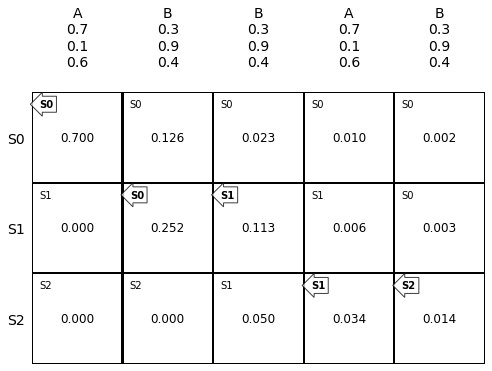

In [6]:
frameprobs, trellis, backptrs, alignment = hmm1.viterbi_trellis(X)
for i in range(len(X)):
    clear_output(wait=True);
    align = False if (i < len(X)-1) else True
    hmmplot.plot_trellis(hmm1,X[0:i+1],plot_backptrs=True,plot_frameprobs=True,plot_alignment=align)
    plt.close()
    time.sleep(2)

In [7]:
# plotting it all once more
empty_line = pd.DataFrame([""]*len(Xl),columns=[""]).T

pd.concat([
    pd.DataFrame(Xl,columns=[""]).T,
    empty_line,
    pd.DataFrame(frameprobs.T,index=hmm1.states),
    empty_line,
    pd.DataFrame(trellis.T,index=hmm1.states),
    empty_line,
    pd.DataFrame(backptrs.T,index=hmm1.states),
    empty_line,
    pd.DataFrame([hmm1.states[i] for i in alignment],columns=[""]).T ]
    ,keys=["OBSERVATIONS",".","LIKELILHOODS","..","TRELLIS","...","BACKPOINTERS","....","ALIGNMENT"] )

0     1     2     3     4
OBSERVATIONS        A     B     B     A     B
.                                            
LIKELILHOODS S0 0.700 0.300 0.300 0.700 0.300
             S1 0.100 0.900 0.900 0.100 0.900
             S2 0.600 0.400 0.400 0.600 0.400
..                                           
TRELLIS      S0 0.700 0.126 0.023 0.010 0.002
             S1 0.000 0.252 0.113 0.006 0.003
             S2 0.000 0.000 0.050 0.034 0.014
...                                          
BACKPOINTERS S0     0     0     0     0     0
             S1     1     0     1     1     0
             S2     2    -1     1     1     2
....                                         
ALIGNMENT          S0    S1    S1    S2    S2

In [8]:
# 16 JUNE 2021, PM
# An HMM with single state phonemes (TH,IH,S) that can recognize THIS vs. IS
#   - enforced begin silence
#   - optional silence at the end
#
# S0 = Silence;  S1 = "TH"; S2 = "IH"; S3="S" 
# Word 1 = This ( SIL S1 S3 S1 S3 [sil])
# Word 2 = is ( SIL S2 S3 S2 S3 [sil])
# 
hmm = libhmm.DHMM(n_states=4,n_symbols=4,prob_style="prob",states= ['SIL','TH','IH ','S'],labels=['A','B','C','D'])
hmm.init_topology(type='lr',selfprob=0.5)
hmm.transmat = np.array([ [0.6, .2, .2, 0.0], [0., .5, .5, .0 ], [ 0., 0.0, .5, .5 ], [0.15, .0, .0, .85] ])

target_emissionprob = np.array([ [0.70, 0.15, 0.1, 0.05 ], [0.2, 0.45, 0.30, 0.05], 
                                [0.2, 0.2 ,.5, .1], [0.1, .15, .15, .60] ])
hmm.emissionmat = spchu.normalize(target_emissionprob,axis=1)
hmm.end_states= [0,3]
#hmm.set_probstyle("log10")
pd.options.display.float_format = '{:,.2f}'.format
hmm.print_model()

# set an observation sequence
Xl=['A','B','C','B','D','A']
X = [hmm.labels.index(x) for x in Xl]
print("OBSERVATION SEQUENCE\n")
print(Xl)
#print(pd.DataFrame([Xl],index=[""]).to_string(index=False))
#
# plotting a partial trellis
print("\nPARTIAL TRELLIS\n")
pd.options.display.float_format = '{:,.4f}'.format
frameprobs, trellis, backptrs, alignment = hmm.viterbi_trellis(X)
empty_line = pd.DataFrame([""]*len(Xl),columns=[""]).T
trellis[3:6,:] = np.nan
df=pd.DataFrame(trellis,index=Xl,columns=hmm.states).T.fillna("")
display(df)

STATE MODEL



,SIL,TH,IH,S
Pinit(S.),1.00,0.00,0.00,0.00
,,,,
P(SIL|S.),0.60,0.00,0.00,0.15
P(TH|S.),0.20,0.50,0.00,0.00
P(IH |S.),0.20,0.50,0.50,0.00
P(S|S.),0.00,0.00,0.50,0.85


OBSERVATION MODEL



,SIL,TH,IH,S
P(A|S.),0.70,0.20,0.20,0.10
P(B|S.),0.15,0.45,0.20,0.15
P(C|S.),0.10,0.30,0.50,0.15
P(D|S.),0.05,0.05,0.10,0.60


OBSERVATION SEQUENCE

['A', 'B', 'C', 'B', 'D', 'A']

PARTIAL TRELLIS



,A,B,C,B,D,A
SIL,0.7000,0.0630,0.0038,,,
TH,0.0000,0.0630,0.0095,,,
IH,0.0000,0.0280,0.0158,,,
S,0.0000,0.0000,0.0021,,,


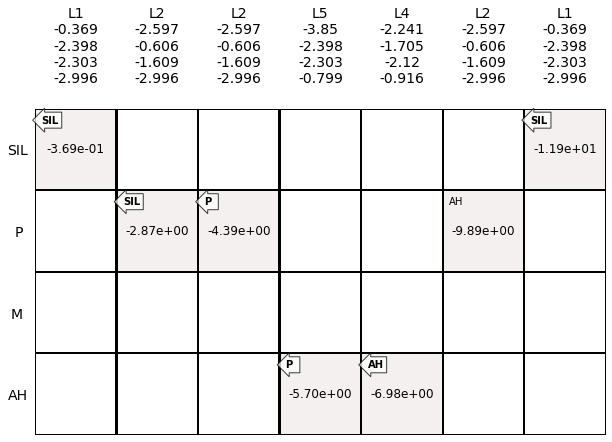

In [15]:
# Solution
fig = hmmplot.plot_trellis(hmm,X,cmap=cmap_caramel,vmin=0,vmax=1,fmt=".2e",
        plot_norm=True,
        plot_frameprobs=True,plot_backptrs=True,
        plot_alignment=True,figsize=(16,6))
#plt.close()

STATE MODEL



,SIL,P,M,AH
Pinit(S.),0.0000,-89.8008,-89.8008,-89.8008
,,,,
P(SIL|S.),-0.3567,-2.9957,-2.9957,-1.6094
P(P |S.),-1.8971,-0.9163,-89.8008,-2.3026
P(M |S.),-1.8971,-89.8008,-0.6931,-2.3026
P(AH|S.),-89.8008,-0.5108,-0.6931,-0.3567


OBSERVATION MODEL



,SIL,P,M,AH
P(L1|S.),-0.3689,-2.3979,-2.3026,-2.9957
P(L2|S.),-2.5974,-0.6061,-1.6094,-2.9957
P(L3|S.),-2.2407,-2.3979,-0.7340,-2.9957
P(L4|S.),-2.2407,-1.7047,-2.1203,-0.9163
P(L5|S.),-3.8501,-2.3979,-2.3026,-0.7985


OBSERVATION SEQUENCE

['L1', 'L2', 'L2', 'L5', 'L4', 'L2', 'L1']

PARTIAL TRELLIS



,L1,L2,L2,L5,L4,L2,L1
SIL,-0.3689,-3.3230,-6.2770,-10.4838,,,
P,-92.1987,-2.8722,-4.3946,-7.7088,,,
M,-92.1034,-3.8755,-6.1781,-9.1738,,,
AH,-92.7966,-92.7966,-6.3787,-5.7039,,,


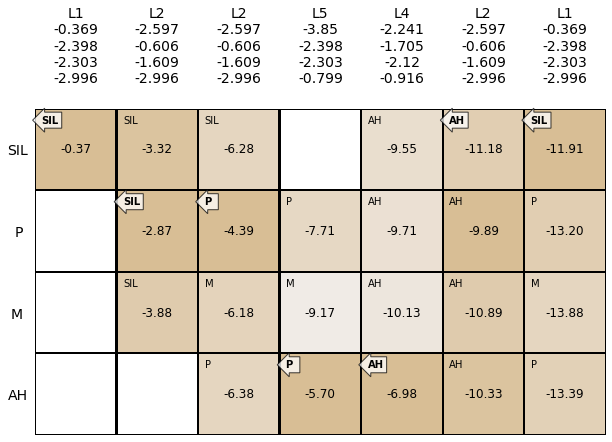

In [16]:
# 17 August 2020
#
# State 0 = Silence;  S1 = "P";  S2="M" ; S3 = "AH";
# Word 1 = pa ( SIL S1 S3  [SIL] )
# Word 2 = pap ( SIL S1 S3 S1 [SIL] )
# Word 3 = ma ( SIL S2 S3  [SIL] )
# Word 4 = mam ( SIL S2 S3 S2 [SIL])
# -- papa, mama, 
#
hmm = libhmm.DHMM(n_states=4,n_symbols=5,prob_style="prob",states= ['SIL','P ','M ','AH'],labels=['L1','L2','L3','L4','L5'])
hmm.transmat = np.array([ [0.7, .15, .15, 0.0], 
                          [ 0.05, .4, 0.0, 0.6 ], 
                          [ 0.05, 0.0, 0.5, 0.5 ], 
                          [ 0.2, .1, 0.1, 0.7] ])

target_emissionprob = np.array([ [0.65, 0.07, 0.1, 0.1, 0.02 ], 
                                [0.1, 0.6, 0.1, 0.2, 0.1], 
                                [0.1, 0.2 ,.48,.12, 0.1], 
                                [0.05, .05, .05, .40, .45] ])
hmm.emissionmat = spchu.normalize(target_emissionprob,axis=1)


hmm.set_probstyle("log")
hmm.print_model()
hmm.end_states=[0]

X = [ 0, 1, 1, 4, 3, 1,   0 ]
Xl = [hmm.labels[i] for i in X]
print("OBSERVATION SEQUENCE\n")
print(Xl)

#
# plotting a partial trellis
print("\nPARTIAL TRELLIS\n")
pd.options.display.float_format = '{:,.4f}'.format
frameprobs, trellis, backptrs, alignment = hmm.viterbi_trellis(X)
empty_line = pd.DataFrame([""]*len(Xl),columns=[""]).T
trellis[4:8,:] = np.nan
df=pd.DataFrame(trellis,index=Xl,columns=hmm.states).T.fillna("")
display(df)

fig = hmmplot.plot_trellis(hmm,X,cmap=cmap_caramel,vmin=-4,vmax=0,fmt=".2f",
        plot_norm=True,
        plot_frameprobs=True,plot_backptrs=True,
        plot_alignment=True,figsize=(16,6))
plt.close()
display(fig)
